In [1]:
# 핵심 패키지(스트리밍 호환 버전)
!pip -q install "datasets<3.0.0" "evaluate<0.5.0" "transformers>=4.38,<4.45" \
                huggingface_hub torchaudio jiwer soundfile

# fsspec/gcsfs 충돌 정리
!pip -q install -U fsspec==2025.3.0 gcsfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 135.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 113.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

In [2]:
import datasets, evaluate, transformers, fsspec, gcsfs, sys
print("datasets:", datasets.__version__)    # ← 2.x 여야 OK
print("evaluate:", evaluate.__version__)    # ← 0.4.x 권장
print("transformers:", transformers.__version__)
print("fsspec:", fsspec.__version__)
print("gcsfs:", gcsfs.__version__)
print("python:", sys.version)

datasets: 2.21.0
evaluate: 0.4.5
transformers: 4.44.2
fsspec: 2025.3.0
gcsfs: 2025.3.0
python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
from datasets import load_dataset, Audio, Dataset, concatenate_datasets
from transformers import (
    WhisperProcessor, WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback
)
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from evaluate import load as load_metric
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

import os, random, numpy as np, torch

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print("Seed fixed to {}.".format(SEED))

Seed fixed to 42.


In [5]:
# 2) 데이터 로드(Streaming -> in-memory)
n_train, n_val, n_test = 200, 100, 100
langs = ["ko","ja","en","de"]

def take_valid(gen, n, lang_code):
    out = []
    for ex in gen:
        if ex.get("audio") is not None and ex.get("sentence"):
            ex = dict(ex)
            ex["locale"] = lang_code
            out.append(ex)
            if len(out) >= n:
                break
    return out

train_data, val_data, test_data = [], [], []
for lang in langs:
    print(f"✅ Loading {lang}...")
    ds_tr = load_dataset("mozilla-foundation/common_voice_16_1", lang, split="train",      streaming=True)
    ds_va = load_dataset("mozilla-foundation/common_voice_16_1", lang, split="validation", streaming=True)
    ds_te = load_dataset("mozilla-foundation/common_voice_16_1", lang, split="test",       streaming=True)
    train_data += take_valid(ds_tr, n_train, lang)
    val_data   += take_valid(ds_va, n_val,   lang)
    test_data  += take_valid(ds_te, n_test,  lang)

random.shuffle(train_data); random.shuffle(val_data); random.shuffle(test_data)
train_dataset = Dataset.from_list(train_data)
val_dataset   = Dataset.from_list(val_data)
test_dataset  = Dataset.from_list(test_data)
print({"train": len(train_dataset), "val": len(val_dataset), "test": len(test_dataset)})

✅ Loading ko...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for mozilla-foundation/common_voice_16_1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_16_1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Reading metadata...: 401it [00:00, 568.24it/s]
Reading metadata...: 235it [00:00, 462.52it/s]
Reading metadata...: 282it [00:00, 564.43it/s]


✅ Loading ja...


Reading metadata...: 9616it [00:00, 11022.65it/s]
Reading metadata...: 6094it [00:01, 6004.71it/s]
Reading metadata...: 6094it [00:00, 6118.43it/s]


✅ Loading en...


Reading metadata...: 1090061it [00:36, 29826.69it/s]
Reading metadata...: 16390it [00:01, 12931.68it/s]
Reading metadata...: 16390it [00:01, 12575.84it/s]


✅ Loading de...


Reading metadata...: 576207it [00:20, 28464.34it/s]
Reading metadata...: 16173it [00:01, 9839.53it/s]
Reading metadata...: 16173it [00:01, 13018.16it/s]


{'train': 800, 'val': 400, 'test': 400}


In [6]:
# 3) 전처리
TARGET_SR = 16000
model_checkpoint = "openai/whisper-small"

processor = WhisperProcessor.from_pretrained(model_checkpoint)
feature_extractor = processor.feature_extractor
tokenizer = processor.tokenizer

train_dataset = train_dataset.cast_column("audio", Audio(sampling_rate=TARGET_SR))
val_dataset   = val_dataset.cast_column("audio",   Audio(sampling_rate=TARGET_SR))
test_dataset  = test_dataset.cast_column("audio",  Audio(sampling_rate=TARGET_SR))

def prepare_dataset(example):
    a = example["audio"]
    example["input_features"] = feature_extractor(a["array"], sampling_rate=TARGET_SR).input_features[0]
    example["labels"] = tokenizer(example["sentence"]).input_ids
    return example

keep_cols = {"input_features","labels","locale"}
proc_train_orig = train_dataset.map(prepare_dataset, remove_columns=[c for c in train_dataset.column_names if c not in keep_cols])
proc_val_orig   = val_dataset.map(  prepare_dataset, remove_columns=[c for c in val_dataset.column_names   if c not in keep_cols])
proc_test_orig  = test_dataset.map( prepare_dataset, remove_columns=[c for c in test_dataset.column_names  if c not in keep_cols])

for ds_ in (proc_train_orig, proc_val_orig, proc_test_orig):
    ds_.set_format(columns=list(keep_cols))

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device, "| Seed:", SEED)

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Device: cuda | Seed: 42


In [7]:
# 4) 모델 로딩 & Whisper generate() 안전 세팅
model = WhisperForConditionalGeneration.from_pretrained(model_checkpoint).to(device)

# pad/eos/start/forced 프롬프트 확정
tok = processor.tokenizer
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

start_id = tok.convert_tokens_to_ids("<|startoftranscript|>")
if start_id is None:
    start_id = processor.get_decoder_prompt_ids(language="english", task="transcribe")[0][1]

forced_ids_en = processor.get_decoder_prompt_ids(language="english", task="transcribe")

for cfg in (model.config, model.generation_config):
    cfg.pad_token_id = tok.pad_token_id
    cfg.eos_token_id = tok.eos_token_id
    cfg.decoder_start_token_id = start_id
    cfg.forced_decoder_ids = forced_ids_en

model.config.use_cache = False
model.config.suppress_tokens = []

# 5) Collator: 라벨 패딩 & decoder_input_ids 생성(우리가 명시 제공)
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    padding: Union[bool, str] = True
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 입력 피처
        input_features = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # 라벨 패딩 + -100 마스킹
        label_features = [{"input_ids": f["labels"]} for f in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels.contiguous()

        # decoder_input_ids (right-shift with <|startoftranscript|>)
        tok = self.processor.tokenizer
        start_id = tok.convert_tokens_to_ids("<|startoftranscript|>")
        if start_id is None:
            start_id = self.processor.get_decoder_prompt_ids(language="english", task="transcribe")[0][1]
        pad_id = tok.pad_token_id

        labels_clean = labels.clone()
        labels_clean[labels_clean == -100] = pad_id

        dec_inp = torch.full_like(labels_clean, fill_value=pad_id)
        dec_inp[:, 0] = start_id
        dec_inp[:, 1:] = labels_clean[:, :-1]

        batch["decoder_input_ids"] = dec_inp.contiguous()
        batch["decoder_attention_mask"] = (dec_inp != pad_id).long()
        batch["input_features"] = batch["input_features"].contiguous()
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [8]:
!apt-get -y install sox libsox-dev libsox-fmt-all

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss
  libsox-fmt-pulse libsox3 libwavpack1
Suggested packages:
  libaudio2 libsndio6.1
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-dev libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base
  libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1 sox
0 upgraded, 17 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,157 kB of archives.
After this operation, 4,262 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao-common all 1.2.2+20180113-1.1ubuntu3 [6,568 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 liba

In [9]:
import numpy as np, torchaudio

def _to_tensor_1ch(x_np):
    x = torch.tensor(np.asarray(x_np, dtype=np.float32))
    if x.dim() == 1:
        x = x.unsqueeze(0)
    return x

def speed_perturb_np(wav_np, sr, rate: float):
    if rate == 1.0:
        return wav_np, sr
    try:
        wav = _to_tensor_1ch(wav_np)
        effects = [["tempo", str(rate)]]  # 피치 보존
        aug, sr_out = torchaudio.sox_effects.apply_effects_tensor(wav, sr, effects)
        return aug.squeeze(0).numpy(), sr_out
    except Exception as e:
        print("[WARN][sox] tempo failed -> fallback(no-aug):", e)
        return wav_np, sr

train_raw_16k = train_dataset.cast_column("audio", Audio(sampling_rate=TARGET_SR))

def augment_copy(ds_raw, rate: float):
    def _aug(b):
        a = b["audio"]
        aug_np, sr_out = speed_perturb_np(a["array"], a["sampling_rate"], rate)
        b = dict(b)
        b["audio"] = {"array": aug_np, "path": None, "sampling_rate": sr_out}
        return b
    ds_aug = ds_raw.map(_aug)
    ds_proc = ds_aug.map(
        prepare_dataset,
        remove_columns=[c for c in ds_aug.column_names if c not in {"input_features","labels","locale"}]
    )
    ds_proc.set_format(columns=["input_features","labels","locale"])
    return ds_proc

# 원본 + 1.1배 속도 증강 샘플 1:1
proc_train_sp11 = augment_copy(train_raw_16k, 1.1)
k = len(proc_train_orig)
m = min(len(proc_train_sp11), k)
proc_train_sp11_sel = proc_train_sp11.shuffle(seed=SEED).select(range(m))
proc_train_mix = concatenate_datasets([proc_train_orig, proc_train_sp11_sel]).shuffle(seed=SEED)
print("Train(orig):", len(proc_train_orig), "Train(1.1 sel):", len(proc_train_sp11_sel), "→ Mixed:", len(proc_train_mix))

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-3231345611.py:15: UserWarning: torchaudio.sox_effects.sox_effects.apply_effects_tensor has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  aug, sr_out = torchaudio.sox_effects.apply_effects_tensor(wav, sr, effects)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Train(orig): 800 Train(1.1 sel): 800 → Mixed: 1600


In [12]:
# 7) Trainer 설정
args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-mix_1p1",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    num_train_epochs=8,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    max_grad_norm=1.0,
    fp16=torch.cuda.is_available(),
    report_to="none",

    predict_with_generate=True,      # eval/predict 시 generate 사용
    generation_max_length=225,

    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    remove_unused_columns=False,
)

trainer_mix11 = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=proc_train_mix,
    eval_dataset=proc_val_orig,
    tokenizer=processor.tokenizer,   # 중요!
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

print("[sanity] before train:", trainer_mix11.state.global_step)
trainer_mix11.train()
print("[sanity] after  train:", trainer_mix11.state.global_step)

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


[sanity] before train: 0


Epoch,Training Loss,Validation Loss
1,No log,2.280026
2,No log,2.318782
3,1.520900,2.447135


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-cust

[sanity] after  train: 600


In [13]:
# 8) 평가
LANG_NAME = {"ko":"korean", "ja":"japanese", "en":"english", "de":"german"}
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

def eval_on(ds_proc, trainer_obj, label, sample_k=10, show_samples=True):
    rows = []
    for lang in ["ko","ja","en","de"]:
        subset = ds_proc.filter(lambda x: x["locale"] == lang)
        if len(subset) == 0:
            print(f"[WARN] No samples for {lang} in {label}")
            rows.append({"set": label, "lang": lang, "WER": float("nan"), "CER": float("nan"), "N": 0})
            continue

        # 언어별 프롬프트 강제 (generate 시 사용)
        forced_ids = processor.get_decoder_prompt_ids(language=LANG_NAME[lang], task="transcribe")
        trainer_obj.model.generation_config.forced_decoder_ids = forced_ids
        trainer_obj.model.generation_config.max_length = 225

        out = trainer_obj.predict(subset)  # predict_with_generate=True → 토큰 시퀀스 반환

        # 예측/정답 디코딩
        preds = tokenizer.batch_decode(out.predictions, skip_special_tokens=True)
        label_ids = np.where(out.label_ids != -100, out.label_ids, tokenizer.pad_token_id)
        refs  = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

        wer = wer_metric.compute(predictions=preds, references=refs)
        cer = cer_metric.compute(predictions=preds, references=refs)
        rows.append({"set": label, "lang": lang, "WER": wer, "CER": cer, "N": len(refs)})

        if show_samples and sample_k > 0:
            print(f"\n[{label}] {lang.upper()} samples (k={min(sample_k, len(refs))})")
            for i, (p, r) in enumerate(zip(preds, refs)):
                if i >= sample_k: break
                print(f"#{i:02d} PRED: {p}")
                print(f"     REF : {r}")
                print("---")

    return pd.DataFrame(rows).sort_values("lang")

print(f"[CHECK] Evaluating on TEST set: size={len(proc_test_orig)} (val={len(proc_val_orig)})")
df_orig = eval_on(proc_test_orig, trainer_mix11, "test_orig", sample_k=10, show_samples=True)
display(df_orig)
df_orig.to_csv("/content/results_mix1p1_test_orig_ONLY.csv", index=False)
print("Saved -> /content/results_mix1p1_test_orig_ONLY.csv")

[CHECK] Evaluating on TEST set: size=400 (val=400)


Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



[test_orig] KO samples (k=10)
#00 PRED: 그러나 실제로 뽑은 숫자는 지난주에 미치지 못한 것으로 나타났다.
     REF : 그러나 실제로 뽑은 숫자는 지난 주에 미치지 못한 것으로 나타났다.
---
#01 PRED: 신앗대는 이렇게 말하며 유서방을 견눈질 해 보았다.
     REF : 싱앗대는 이렇게 말하며 유서방을 곁눈질해 보았다.
---
#02 PRED: 신철이는 어짖 보면 감정을 가진 사람같지 않아 보였다.
     REF : 신철이는 어찌 보면 감정을 가진 사람 같지 않아 보였다.
---
#03 PRED:  내다보니깐 엉덕 어려웠던 집에 불이 붙으며 사람들이 왔다갔다 야단이었습니다.
     REF : 내다보니까 언덕 아래 어떤 집에 불이 붙으며 사람들이 왔다갔다 야단이었습니다.
---
#04 PRED:  인력화가 무거워지네 그의 몸은 이상하게도 가벼졌고
     REF : 인력거가 무거워지매 그의 몸은 이상하게도 가벼워졌고
---
#05 PRED: 마스크 잘 쓰고 다니고 길쥐심에서 다녀와
     REF : 마스크 잘 쓰고 다니고, 길 조심해서 다녀와.
---
#06 PRED: 나를 나와준 고향과담도 더 정이 들었고요.
     REF : 나를 낳어 준 고향버덤두 더 정이 들었고요.
---
#07 PRED: 선비는 생각지 않은 이 말에 앞이 아득해지며 방안이 팅팅 놀았다.
     REF : 선비는 생각지 않은 이 말에 앞이 아뜩해지며 방 안이 핑핑 돌았다.
---
#08 PRED: 벽을 새로 감독과 그가 마주 누은 것이 직각되자 불쾌하였다.
     REF : 벽을 새로 감독과 그가 마주 누운 것이 직각 되자 불쾌하였다.
---
#09 PRED: 내가 너는 옥점인 연과 조금도 달리 생각지 않는다.
     REF : 내가 너는 옥점이년과 조금도 달리 생각지 않는다.
---


Filter:   0%|          | 0/400 [00:00<?, ? examples/s]


[test_orig] JA samples (k=10)
#00 PRED: 福島県広野町
     REF : 福島県広野町
---
#01 PRED: だがことわる
     REF : だが断る
---
#02 PRED: そしていくら見舞いとしても君が悪ければ悪いほど書いてその髪をじっと見つめないではいられませんでした
     REF : そして、いくら見まいとしても、きみが悪ければ悪いほど、かえってその影を、じっと見つめないではいられませんでした。
---
#03 PRED: ニーダザク選手のシュートはハノファーである
     REF : ニーダーザクセン州の州都はハノーファーである
---
#04 PRED: そこで自分で出かけていて、調べ始めました。彼はさんざん探し回りました。
     REF : そこで自分で出かけて行って、調べはじめました。かれはさんざんさがしまわりました。
---
#05 PRED: ok
     REF : 「おやおや、汚いやつめまた出て来やがったな。」とイワンは言いました。
---
#06 PRED: そこから見ていると、その徳はだんだんの上に立ち上がって、右階の旅の旅のほうを振り向いて、何かを覚えで叫びました。
     REF : そこから見ていると、その男は段々の上に立ち上って、右隣りの畑の方を振り向いて、何か大声で叫びました。
---
#07 PRED: 今日の天気は晴れ
     REF : 今日の天気は晴れ
---
#08 PRED: さあ行こう。
     REF : さあ、行こう。
---
#09 PRED: 行程は否定によって買い換えされたものでなければならない。
     REF : その肯定は否定によって媒介されたものでなければならぬ。
---


Filter:   0%|          | 0/400 [00:00<?, ? examples/s]


[test_orig] EN samples (k=10)
#00 PRED: Hello, this is one of my most famous and most important to the class of the class, known as the Romani-Libbert-Huppernitz.
     REF : Enoxaparin belongs to the class of drugs known as low molecular weight heparins.
---
#01 PRED: Eight.
     REF : eight
---
#02 PRED: Do you mean it?
     REF : Do you mean it?
---
#03 PRED: You shall see the other guy, Spice Fillet, how good at fighting he is.
     REF : You should see the other guy, specifically, how good at fighting he is.
---
#04 PRED: Karina is still enough of dancing with the stars, most at the following month.
     REF : Karina Smirnoff of "Dancing With The Stars" hosted the following month.
---
#05 PRED: The nearest railway station is at Rohnford.
     REF : The nearest railway station is at Romford.
---
#06 PRED: He ended up running to the bars, which fortify the windows of the first floor.
     REF : He ended up running to the bars which fortified the windows of the first floor.
---
#07 P

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]


[test_orig] DE samples (k=10)
#00 PRED: Wenn nicht, dann läckt man sie irgendwo hin, woplatzes.
     REF : Wenn nicht, dann legt man sie irgendwo hin, wo Platz ist.
---
#01 PRED: Wie ist die derzeitige Verkehrssituation?
     REF : Wie ist die derzeitige Verkehrssituation?
---
#02 PRED: Aus dem Prozess haben der Hexen Verfolgen mit dem keinerlten Tischen als Hete bekannt.
     REF : Aus den Prozessakten der Hexenverfolgung sind keine authentischen Rezepte bekannt.
---
#03 PRED: Er er rang den ersten Platz in seiner Hubraumklasse.
     REF : Er errang den ersten Platz in seiner Hubraumklasse.
---
#04 PRED: Auch du Schreck!
     REF : Ach du Schreck!
---
#05 PRED: Abschließend möchte ich Ihnen gerne etwas sehr wichtiges mitteilen.
     REF : Abschließend möchte ich Ihnen gerne etwas sehr Wichtiges mitteilen.
---
#06 PRED: Ihr sofortestrechen erschienen in Morde-Magazinen mit der Waukart das Basa Maria.
     REF : Ihre Fotostrecken erschienen in Modemagazinen wie der Vogue, Harper’s Baza

,set,lang,WER,CER,N
3,test_orig,de,0.402861,0.171657,100
2,test_orig,en,0.256983,0.128580,100
1,test_orig,ja,0.864865,0.354854,100
0,test_orig,ko,0.452603,0.182523,100


Saved -> /content/results_mix1p1_test_orig_ONLY.csv


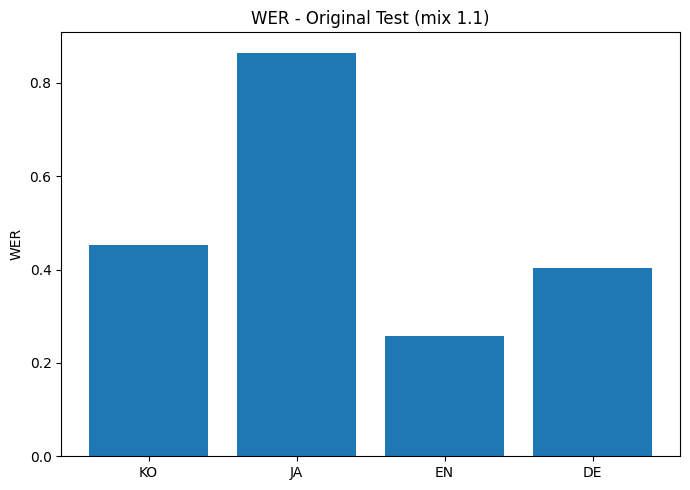

In [14]:
import matplotlib.pyplot as plt

# 9) 시각화
def bar_lang(df, label):
    plt.figure(figsize=(7,5))
    langs = ["ko","ja","en","de"]
    vals = []
    for l in langs:
        row = df[df["lang"]==l]
        vals.append(float(row["WER"].values[0]) if len(row) else float("nan"))
    plt.bar([l.upper() for l in langs], vals)
    plt.title(f"WER - {label}")
    plt.ylabel("WER")
    plt.tight_layout()
    plt.show()

bar_lang(df_orig, "Original Test (mix 1.1)")